# Pre-process networks


In [1]:
import pandas as pd
import os
import networkx as nx
import numpy as np
import pickle as pkl

In [3]:
PATH = "D:/Projects/cTaG2.0"
DATAPATH = "D:/Projects/data/cTaG2.0"

# PATH = "/data/malvika/cTaG2.0"
# DATAPATH = "/data/malvika/data/cTaG2.0"

The cut-off taken as 700, which corresponds to 0.7 confidence score. String db suggests 0.9 for very high cut-off and 0.7 high confidence.

In [4]:
%%time
# Load data
os.chdir(DATAPATH + "/network")
fname="9606.protein.links.detailed.v11.5.txt.gz.inproc"
data_string = pd.read_csv(fname, sep=" ", header=0)
data_string = data_string[(data_string.experimental > 700) | (data_string.database >700)]

Wall time: 38.2 s


In [5]:
data_string.shape

(260786, 10)

In [6]:
%%time
# load network
os.chdir(DATAPATH + "/network")
fname = "9606.protein.aliases.v11.5.txt"
data_map = pd.read_csv(fname, sep="\t", header=0)
data_map = data_map[data_map.source == "BioMart_HUGO"]
data_map.drop_duplicates(subset=["#string_protein_id"], keep=False, inplace=True)
data_map.index = data_map["#string_protein_id"]

temp = [data_map.loc[x, "alias"] if x in data_map.index else np.nan for x in data_string.protein1]
data_string["gene1"] = temp
temp = [data_map.loc[x, "alias"] if x in data_map.index else np.nan for x in data_string.protein2]
data_string["gene2"] = temp
data_string = data_string.dropna(axis=0)

Wall time: 15.3 s


### Define graph for PPI network

In [7]:
G = nx.Graph()
G = nx.from_pandas_edgelist(data_string, 'gene1', 'gene2',
                            edge_attr=['experimental', 'database', 'combined_score'])

### Degree of nodes

In [9]:
%%time
deg = G.degree()
os.chdir(PATH + "/data/network")
fname = "string_degree.pkl"
with open(fname, 'wb') as f:
    pkl.dump(deg, f)

CPU times: user 193 ms, sys: 12.1 ms, total: 205 ms
Wall time: 200 ms


### Closeness centrality

In [10]:
%%time
cc = nx.closeness_centrality(G)
os.chdir(PATH + "/data/network")
fname = "string_cc.pkl"
with open(fname, 'wb') as f:
    pkl.dump(cc, f)

CPU times: user 4min 16s, sys: 182 ms, total: 4min 16s
Wall time: 4min 16s


### Betweeness centrality

In [11]:
%%time
bc = nx.betweenness_centrality(G, k=int(G.number_of_nodes()/2), weight='combined_score')
os.chdir(PATH + "/data/network")
fname = "string_bc.pkl"
with open(fname, 'wb') as f:
    pkl.dump(bc, f)

CPU times: user 31min 10s, sys: 1.64 s, total: 31min 12s
Wall time: 31min 12s


### Neighbours of genes

In [8]:
def getneighbors(gene, G, n = 1):
    """
    

    Parameters
    ----------
    gene : TYPE
        DESCRIPTION.
    G : TYPE
        DESCRIPTION.
    n : TYPE, optional
        DESCRIPTION. The default is 1.

    Returns
    -------
    None.

    """
    neighbors = [None] * n
    for i in range(n):
        if i == 0:
            neighbors[i] = list(G.neighbors(gene))
        else:           
            for g in neighbors[i - 1]:
                if neighbors[i] is None:
                    neighbors[i] =  list(G.neighbors(g))
                else:
                    neighbors[i] =  neighbors[i] + list(G.neighbors(g))
    return [n for neigh in neighbors for n in neigh]

While the networkx package can be used to find immediate neighbours of a gene, for generation of RNA features we require all the neighbours at 1 to n steps. The function defined above helps find all neighbours at >=n steps.

Given below is a code for generating a dictionary for nodes in graph and their neighbours. the value of n can be changed as desired. The file is uploaded for generating RNA features.

In [10]:
%%time
n = 2
neighbors = {}
for gene in G.nodes:
    neighbors[gene] = getneighbors(gene, G, n = n)
os.chdir(PATH + "/data/network")
fname = "string_neigh_{}.pkl".format(n)
with open(fname, 'wb') as f:
    pkl.dump(neighbors, f)

Wall time: 7.18 s


### Save network

In [12]:
os.chdir(PATH + "/data/network")
fname = "string_graph.pkl"
with open(fname, 'wb') as f:
    pkl.dump(G, f)

In [5]:
data_string = data_string.sample(frac=0.2).reset_index(drop=True)

In [6]:
data_string.shape

(52157, 10)

In [5]:
data_string.experimental.min()

0

In [6]:
data_string.experimental.max()

999

In [7]:
data_string.shape

(258882, 12)

In [8]:
data_string[data_string.experimental >700].shape

(98130, 12)

In [5]:
data_string[data_string.database >700].shape

(193660, 10)

In [9]:
98130+193660

291790

In [11]:
data_string[(data_string.experimental > 700) | (data_string.database >700)].shape

(258882, 12)

In [7]:
data_string.columns

Index(['protein1', 'protein2', 'neighborhood', 'fusion', 'cooccurence',
       'coexpression', 'experimental', 'database', 'textmining',
       'combined_score'],
      dtype='object')

In [12]:
data_string[(data_string.experimental > 700) | (data_string.database >700)].gene1.unique().shape

(11164,)

In [21]:
data_string[(data_string.experimental > 700) | (data_string.database > 700)].gene2.unique().shape

(11164,)

In [44]:
len(set(data_string[(data_string.experimental > 700) | (data_string.database >700)].gene1.unique()).union(data_string[(data_string.experimental > 700) | (data_string.database >700)].gene2.unique()))

11164

In [45]:
G = nx.Graph()

data_temp = data_string[(data_string.experimental > 0.7) & (data_string.database > 0.7)]

In [46]:
data_temp.shape

(180874, 12)

In [33]:
data_string.shape

(11741814, 12)

In [22]:
data_temp = data_string[(data_string.experimental > 900) | (data_string.database > 900)]
data_temp.shape

(34334, 12)

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

(array([6.904228e+06, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        3.566000e+03, 6.320940e+05, 2.896060e+05, 3.134720e+05,
        5.350000e+04, 6.545800e+04, 2.942620e+05, 1.367960e+05,
        1.608020e+05, 2.966200e+05, 4.462820e+05, 4.620940e+05,
        2.676400e+05, 2.085720e+05, 1.527840e+05, 3.254600e+04,
        3.196600e+04, 1.222240e+05, 3.702600e+04, 3.351200e+04,
        1.111420e+05, 5.112800e+04, 2.160800e+04, 2.014100e+05,
        3.901800e+04, 2.330800e+04, 1.200400e+04, 1.576200e+04,
        1.022200e+04, 1.066400e+04, 3.326000e+04, 8.942000e+03,
        2.614800e+04, 7.316000e+03, 1.179000e+04, 9.668000e+03,
        6.382000e+03, 4.456000e+03, 4.130000e+03, 3.682000e+03,
        1.672000e+03, 2.036000e+03, 4.052000e+03, 3.964000e+03,
        9.108000e+03, 5.362000e+03, 3.696000e+03, 1.492000e+03,
        7.152000e+03, 4.828000e+03, 2.242000e+03, 3.628000e+03,
        1.868000e+03, 1.508000e+03, 1.340000e+03, 1.360000e+03,
        2.378000e+03, 3.714000e+03, 2.41

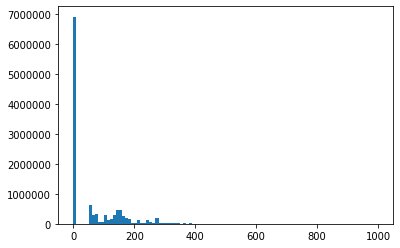

In [27]:
plt.hist(data_string.experimental, bins=100)

(array([1.134149e+07, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 7.630000e+03, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        6.442000e+03, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 1.164000e+04,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        2.333200e+04, 0.000000e+00, 0.00

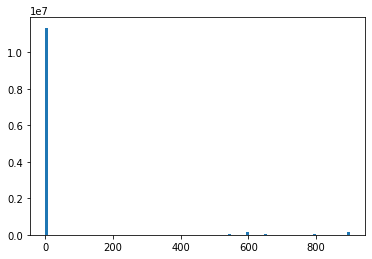

In [28]:
plt.hist(data_string.database, bins=100)

{'boxes': [<matplotlib.lines.Line2D at 0x7fa655038190>],
 'caps': [<matplotlib.lines.Line2D at 0x7fa6550ca410>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fa6550c91d0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fa6550c7410>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7fa6550c9990>,
  <matplotlib.lines.Line2D at 0x7fa6550c9390>]}

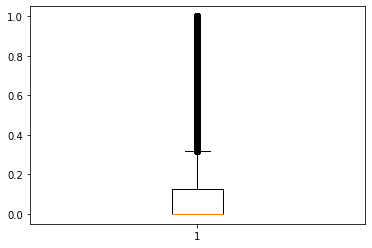

In [18]:
plt.boxplot((data_string.experimental - data_string.experimental.min()) /data_string.experimental.max())